In [ ]:
# before this run the following commands on terminal
#pip install mlflow
#mlflow server --host 127.0.0.1 --port 8080
# in this way server first gets start then it is tracked in this ipynb after performing the following steps

In [1]:
#Importing Dependencies
from mlflow import MlflowClient
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor

In [2]:
#Configuring the MLflow Tracking Client
client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

In [3]:
all_experiments = client.search_experiments()

print(all_experiments)

[<Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1756402031780, experiment_id='0', last_update_time=1756402031780, lifecycle_stage='active', name='Default', tags={}>]


In [6]:
default_experiment = [
    {"name": experiment.name, "lifecycle_stage": experiment.lifecycle_stage}
    for experiment in all_experiments
    if experiment.name == "Default"
][0]

pprint(default_experiment)

{'lifecycle_stage': 'active', 'name': 'Default'}


### Creating a new Experiment

In this section, we'll:

* create a new MLflow Experiment
* apply metadata in the form of Experiment Tags

In [7]:
experiment_description = (
    "This is the grocery forecasting project. "
    "This experiment contains the produce models for apples."
)

experiment_tags = {
    "project_name": "grocery-forecasting",
    "store_dept": "produce",
    "team": "stores-ml",
    "project_quarter": "Q3-2023",
    "mlflow.note.content": experiment_description,
}

produce_apples_experiment = client.create_experiment(name="Apple_Models", tags=experiment_tags)

In [8]:
# Use search_experiments() to search on the project_name tag key

apples_experiment = client.search_experiments(
    filter_string="tags.`project_name` = 'grocery-forecasting'"
)

pprint(apples_experiment[0])

<Experiment: artifact_location='mlflow-artifacts:/683920470408745319', creation_time=1756402415452, experiment_id='683920470408745319', last_update_time=1756402415452, lifecycle_stage='active', name='Apple_Models', tags={'mlflow.note.content': 'This is the grocery forecasting project. This '
                        'experiment contains the produce models for apples.',
 'project_name': 'grocery-forecasting',
 'project_quarter': 'Q3-2023',
 'store_dept': 'produce',
 'team': 'stores-ml'}>


### Running our first model training

In this section, we'll:

* create a synthetic data set that is relevant to a simple demand forecasting task
* start an MLflow run
* log metrics, parameters, and tags to the run
* save the model to the run
* register the model during model logging

#### Synthetic data generator for demand of apples

Keep in mind that this is purely for demonstration purposes. 

The demand value is purely artificial and is deliberately covariant with the features. This is not a particularly realistic real-world scenario (if it were, we wouldn't need Data Scientists!). 

In [11]:
from datetime import datetime, timedelta

import numpy as np
import pandas as pd


def generate_apple_sales_data_with_promo_adjustment(base_demand: int = 1000, n_rows: int = 5000):
    """
    Generates a synthetic dataset for predicting apple sales demand with seasonality and inflation.

    This function creates a pandas DataFrame with features relevant to apple sales.
    The features include date, average_temperature, rainfall, weekend flag, holiday flag,
    promotional flag, price_per_kg, and the previous day's demand. The target variable,
    'demand', is generated based on a combination of these features with some added noise.

    Args:
        base_demand (int, optional): Base demand for apples. Defaults to 1000.
        n_rows (int, optional): Number of rows (days) of data to generate. Defaults to 5000.

    Returns:
        pd.DataFrame: DataFrame with features and target variable for apple sales prediction.

    Example:
        >>> df = generate_apple_sales_data_with_seasonality(base_demand=1200, n_rows=6000)
        >>> df.head()
    """

    # Set seed for reproducibility
    np.random.seed(9999)

    # Create date range
    dates = [datetime.now() - timedelta(days=i) for i in range(n_rows)]
    dates.reverse()

    # Generate features
    df = pd.DataFrame(
        {
            "date": dates,
            "average_temperature": np.random.uniform(10, 35, n_rows),
            "rainfall": np.random.exponential(5, n_rows),
            "weekend": [(date.weekday() >= 5) * 1 for date in dates],
            "holiday": np.random.choice([0, 1], n_rows, p=[0.97, 0.03]),
            "price_per_kg": np.random.uniform(0.5, 3, n_rows),
            "month": [date.month for date in dates],
        }
    )

    # Introduce inflation over time (years)
    df["inflation_multiplier"] = 1 + (df["date"].dt.year - df["date"].dt.year.min()) * 0.03

    # Incorporate seasonality due to apple harvests
    df["harvest_effect"] = np.sin(2 * np.pi * (df["month"] - 3) / 12) + np.sin(
        2 * np.pi * (df["month"] - 9) / 12
    )

    # Modify the price_per_kg based on harvest effect
    df["price_per_kg"] = df["price_per_kg"] - df["harvest_effect"] * 0.5

    # Adjust promo periods to coincide with periods lagging peak harvest by 1 month
    peak_months = [4, 10]  # months following the peak availability
    df["promo"] = np.where(
        df["month"].isin(peak_months),
        1,
        np.random.choice([0, 1], n_rows, p=[0.85, 0.15]),
    )

    # Generate target variable based on features
    base_price_effect = -df["price_per_kg"] * 50
    seasonality_effect = df["harvest_effect"] * 50
    promo_effect = df["promo"] * 200

    df["demand"] = (
        base_demand
        + base_price_effect
        + seasonality_effect
        + promo_effect
        + df["weekend"] * 300
        + np.random.normal(0, 50, n_rows)
    ) * df["inflation_multiplier"]  # adding random noise

    # Add previous day's demand
    df["previous_days_demand"] = df["demand"].shift(1)
    df["previous_days_demand"].fillna(method="bfill", inplace=True)  # fill the first row

    # Drop temporary columns
    df.drop(columns=["inflation_multiplier", "harvest_effect", "month"], inplace=True)

    return df

In [12]:
# Generate the dataset!

data = generate_apple_sales_data_with_promo_adjustment(base_demand=1_000, n_rows=1_000)

data[-20:]

C:\Users\ayush\AppData\Local\Temp\ipykernel_16508\3503073555.py:83: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["previous_days_demand"].fillna(method="bfill", inplace=True)  # fill the first row
C:\Users\ayush\AppData\Local\Temp\ipykernel_16508\3503073555.py:83: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["previous_days_demand"].fillna(method="bfill", inplace=True)  # fill the first row


,date,average_temperature,rainfall,weekend,holiday,price_per_kg,promo,demand,previous_days_demand
980,2025-08-09 13:40:14.337991,34.130183,1.454065,1,0,1.449177,0,1326.306290,1029.418398
981,2025-08-10 13:40:14.337991,32.353643,9.462859,1,0,2.856503,0,1169.129427,1326.306290
982,2025-08-11 13:40:14.337991,18.816833,0.391470,0,0,1.326429,0,990.616709,1169.129427
983,2025-08-12 13:40:14.337991,34.533012,2.120477,0,0,0.970131,0,1068.802075,990.616709
984,2025-08-13 13:40:14.337991,23.057202,2.365705,0,0,1.049931,0,1019.486305,1068.802075
985,2025-08-14 13:40:14.337991,34.810165,3.089005,0,0,2.035149,0,1002.564672,1019.486305
986,2025-08-15 13:40:14.337991,29.208905,3.673292,0,0,2.518098,0,1086.143402,1002.564672
987,2025-08-16 13:40:14.337991,16.428676,4.077782,1,0,1.268979,0,1420.207186,1086.143402
988,2025-08-17 13:40:14.337991,32.067512,2.734454,1,0,0.762317,0,1396.939894,1420.207186
989,2025-08-18 13:40:14.337991,31.938203,13.883486,0,0,1.153301,0,994.409540,1396.939894


### Train and log the model

We're now ready to import our model class and train a ``RandomForestRegressor``

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import mlflow

# Use the fluent API to set the tracking uri and the active experiment
mlflow.set_tracking_uri("http://127.0.0.1:8080")

# Sets the current active experiment to the "Apple_Models" experiment and returns the Experiment metadata
apple_experiment = mlflow.set_experiment("Apple_Models")

# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "apples_rf_test"

# Define an artifact path that the model will be saved to.
artifact_path = "rf_apples"

In [14]:
# Split the data into features and target and drop irrelevant date field and target field
X = data.drop(columns=["date", "demand"])
y = data["demand"]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    "n_estimators": 100,
    "max_depth": 6,
    "min_samples_split": 10,
    "min_samples_leaf": 4,
    "bootstrap": True,
    "oob_score": False,
    "random_state": 888,
}

# Train the RandomForestRegressor
rf = RandomForestRegressor(**params)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Predict on the validation set
y_pred = rf.predict(X_val)

# Calculate error metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

# Assemble the metrics we're going to write into a collection
metrics = {"mae": mae, "mse": mse, "rmse": rmse, "r2": r2}

# Initiate the MLflow run context
with mlflow.start_run(run_name=run_name) as run:
    # Log the parameters used for the model fit
    mlflow.log_params(params)

    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)

    # Log an instance of the trained model for later use
    mlflow.sklearn.log_model(sk_model=rf, input_example=X_val, name=artifact_path)

c:\Users\ayush\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🏃 View run apples_rf_test at: http://127.0.0.1:8080/#/experiments/683920470408745319/runs/8a9b93525bee4eed9e2c46414b0b1aa5
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/683920470408745319


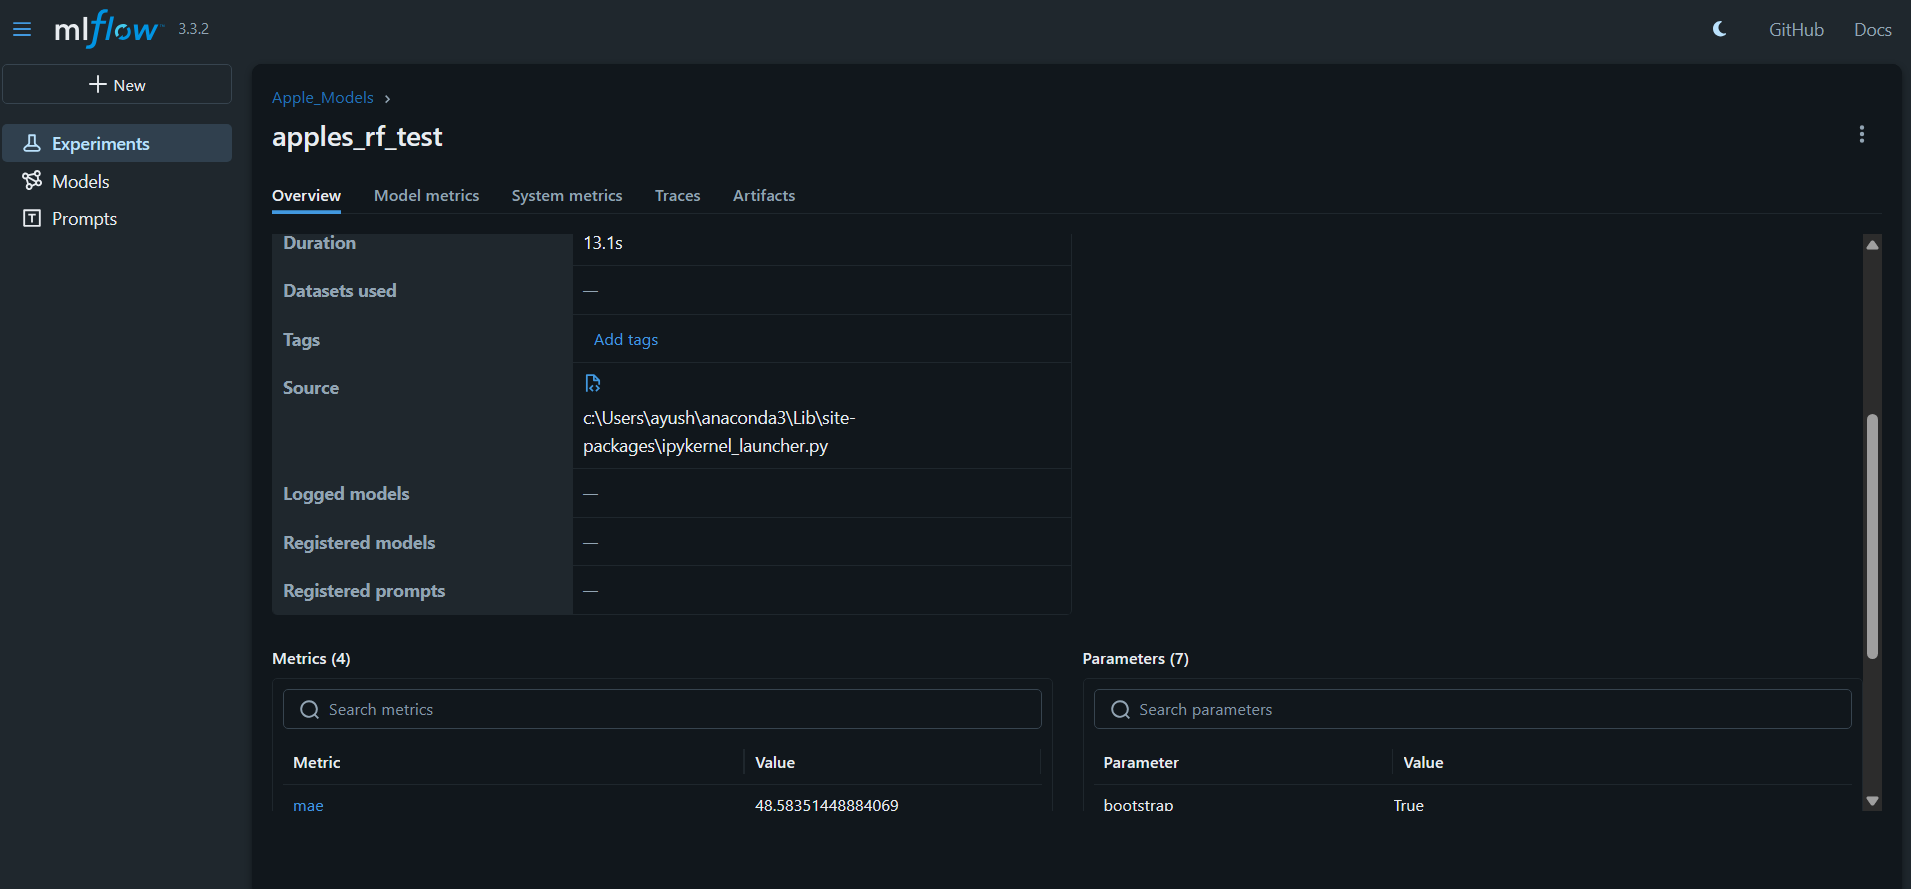